# 1. Main Workflow

This notebook describes the main workflow of normative modelling (NM). It contains the accompanying code for the manuscript: ___, but can also be used as a standalone learning tool for NM.

## 1.0 Setting up the environment

-----

<details>
<summary><b>System requirements</b></summary>

To follow this guide, you will need:
- Either a Mac, Linux, or Windows machine with WSL (Windows Subsystem for Linux) installed.
- About ___ GB of free disk space (for the data and the environment)
- About ___ GB of RAM (more is better, but not required)
- A decent processor (we recommend a multi-core CPU)
- A working internet connection (for installing the packages and downloading the data)

For Windows users with WSL, everything that follows will be done in the WSL terminal. You will have to follow the installation instructions for Linux/Mac. 

</details>

-----

<details>
<summary><b>Setting up Anaconda</b></summary>

Anaconda is a free and open-source distribution of the Python and R programming languages for scientific computing, that aims to simplify package management and deployment. We highly recommend using Anaconda (or an alternative like miniconda or venv) to manage your python environment. We will use Anaconda in this tutorial.

Follow the instructions on the anaconda website: https://www.anaconda.com/docs/getting-started/anaconda/install

Verify the installation by running the following command in your terminal:

```bash
conda --version
```

If you see the version number, you are good to go.

</details>

-----

<details>
<summary><b>Creating an environment and install the PCNtoolkit</b></summary>

Choose an environment name, here we will use `ptk` as a placeholder.

```bash
conda create -n ptk python=3.12
conda activate ptk
pip install pcntoolkit==1.1.0
conda install -c conda-forge jupyter ipykernel ipywidgets
```

Now to verify that the installation is successful, run the following code:

```bash
python -c "import pcntoolkit as pcn; print(pcn.__version__)" 
```

This should print `1.1.0` without any errors.

</details>

-----

## 1.1 Data Selection 🥦 

-----
### Data inclusion criteria

A large reference - or normative - set is required to train a well-calibrated normative model. There are two types of uncertainty that have to be considered when building a normative model; epistemic and aleatoric uncertainty. The epistemic uncertainty is the uncertainty in our knowledge, while the aleatoric uncertainty is due to the natural variation in the population. The latter is what we aim to capture with our normative models, and to model it as accurately as possible, the former has to be minimized. As the epistemic uncertainty decreases with the size of the training data, it is desired to have a large reference set.

What can be considered a reference set depends on the research question. If the goal is to parse deviations from a healthy population, the reference set should include only healthy participants. If the goal is to parse heterogeneity within a clinical cohort, one could choose to use a set of participants with that particular condition as the reference set. For instance, if one is interested to parse heterogeneity within a clinical cohort of patients with major depressive disorder (MDD), the reference set could include MDD patients who have responded well to medication. 

We will use cortical thickness IDP's derived from several different datasets, which we list below. The datasets are all pre-processed, and included in this repo. All the preprocessing was done using [freesurfer](https://surfer.nmr.mgh.harvard.edu/), with the `recon-all` command. We extracted the mean cortical thickness values following the Destrieux parcellation [1].

We use the FCON1000 dataset, which is freely available at the ([FCON1000 website](https://fcon_1000.projects.nitrc.org/indi/fcp_abcd/abcd.html).
). In addition, we will use a number of clinical datasets from the openneuro portal:

1. [ds003568](https://openneuro.org/datasets/ds003568/versions/1.0.4) - Contains data from 49 subjects (31F, 18M), aged between 12 and 19 (mean 15.9, std 1.8). Clinical labels are Healthy Control (HC) (20) and Major Depression Disorder (MDD) (29) [2]
2. [ds003653](https://openneuro.org/datasets/ds003653/versions/1.0.0) - Contains data from 73 subjects (56F, 17M), aged between 19 and 44 (mean 29.1, std 6.6). Clinical labels are HC (39) and MDD (33s) [3]

[1] Destrieux, Christophe, et al. "Automatic parcellation of human cortical gyri and sulci using standard anatomical nomenclature." Neuroimage 53.1 (2010): 1-15.
[2] Lucrezia Liuzzi, Katharine Chang, Charles Zheng, Hanna Keren, Dipta Saha, Dylan Nielson and Argyris Stringaris, Magnetoencephalographic Correlates of Mood and Reward Dynamics in Human Adolescents, Cerebral Cortex 2021

[3] Anna Manelis, Ph.D., David A.A. Baranger, Ph.D., Skye Satz, B.S., Rachel Ragozzino, M.A., Satish Iyengar, Ph.D., Holly A. Swartz, M.D., Yaroslav O. Halchenko, Ph.D. Cortical myelin measured by the T1w/T2w ratio in individuals with depressive disorders and healthy controls.

To cite the associated paper use: Baranger D, Halchenko YO, Satz S, Ragozzino R, Iyengar S, Swartz HA, Manelis A. 2021. Aberrant levels of cortical myelin distinguish individuals with unipolar depression from healthy controls, DOI: 10.1101/2021.02.25.21252472v2

In [1]:
import pandas as pd

try:
    df = pd.read_csv("../data/fcon1000.csv")
except FileNotFoundError:
    # Load the data from the GH repo if the local file is not present
    df = pd.read_csv(
        "https://raw.githubusercontent.com/predictive-clinical-neuroscience/pu25_code/refs/heads/main/data/fcon1000.csv"
    )
df["sex"] = df.apply(lambda x: {0: "F", 1: "M"}[x["sex"]], axis=1)
print(df['site'].unique())
df.describe()


['AnnArbor_a' 'AnnArbor_b' 'Atlanta' 'Baltimore' 'Bangor' 'Beijing_Zang'
 'Berlin_Margulies' 'Cambridge_Buckner' 'Cleveland' 'ICBM' 'Leiden_2180'
 'Leiden_2200' 'Milwaukee_b' 'Munchen' 'NewYork_a' 'NewYork_a_ADHD'
 'Newark' 'Oulu' 'Oxford' 'PaloAlto' 'Pittsburgh' 'Queensland'
 'SaintLouis']


,age,lh_G_and_S_frontomargin,lh_G_and_S_occipital_inf,lh_G_and_S_paracentral,lh_G_and_S_subcentral,lh_G_and_S_transv_frontopol,lh_G_and_S_cingul-Ant,lh_G_and_S_cingul-Mid-Ant,lh_G_and_S_cingul-Mid-Post,lh_G_cingul-Post-dorsal,...,rh_S_pericallosal,rh_S_postcentral,rh_S_precentral-inf-part,rh_S_precentral-sup-part,rh_S_suborbital,rh_S_subparietal,rh_S_temporal_inf,rh_S_temporal_sup,rh_S_temporal_transverse,rh_MeanThickness
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,...,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000
mean,28.251224,2.372937,2.383840,2.310856,2.698957,2.610888,2.753899,2.697544,2.632217,2.959526,...,1.979635,2.104468,2.451929,2.417430,2.497463,2.401750,2.474282,2.495482,2.554019,2.485162
std,13.464724,0.192185,0.170751,0.190248,0.182866,0.225693,0.179482,0.179243,0.158939,0.195792,...,0.281369,0.161474,0.160934,0.182979,0.400458,0.162933,0.207039,0.139035,0.313909,0.097570
min,7.880000,1.653000,1.889000,1.383000,2.147000,1.910000,2.151000,2.158000,2.028000,2.240000,...,1.144000,1.635000,1.744000,1.503000,1.585000,1.897000,1.583000,1.943000,1.618000,2.056150
25%,21.000000,2.244250,2.267250,2.184250,2.574000,2.460000,2.629000,2.581000,2.529000,2.840250,...,1.773250,1.997000,2.354000,2.307000,2.208250,2.291250,2.365000,2.406500,2.330000,2.423033
50%,22.000000,2.361500,2.382000,2.313000,2.691500,2.608000,2.749500,2.703500,2.641000,2.956000,...,1.943500,2.100000,2.450000,2.433000,2.437000,2.400000,2.498500,2.499000,2.538500,2.487950
75%,29.000000,2.486000,2.498750,2.444000,2.821000,2.750750,2.865000,2.818750,2.739000,3.088500,...,2.155500,2.218750,2.554000,2.537750,2.730500,2.508000,2.607000,2.587000,2.768500,2.547210
max,85.000000,3.047000,3.010000,3.021000,3.438000,3.432000,3.542000,3.330000,3.143000,3.608000,...,3.119000,2.681000,3.042000,2.960000,4.066000,2.944000,3.111000,2.978000,3.581000,2.837260


In [2]:
try:
    openneuro_df = pd.read_csv("../data/openneuro.csv")
except FileNotFoundError:
    # Load the data from the GH repo if the local file is not present
    openneuro_df = pd.read_csv(
        "https://raw.githubusercontent.com/predictive-clinical-neuroscience/pu25_code/refs/heads/main/data/openneuro.csv"
    )
openneuro_df.describe()
# Do this when the new data comes in
# # Make sure all datasets follow the same naming convention
# openneuro_df.loc[openneuro_df["group"] == "HV", "group"] = "HC"
# openneuro_df.loc[openneuro_df["group"] == "UD", "group"] = "MDD"
# openneuro_df.rename(columns={"dataset": "site"}, inplace=True)
# openneuro_df = openneuro_df[openneuro_df['group'].isin(['HC','MDD'])]
# openneuro_df.to_csv("../data/openneuro.csv")


,Unnamed: 0,lh_G_Ins_lg_and_S_cent_ins,lh_G_and_S_cingul-Ant,lh_G_and_S_cingul-Mid-Ant,lh_G_and_S_cingul-Mid-Post,lh_G_and_S_frontomargin,lh_G_and_S_occipital_inf,lh_G_and_S_paracentral,lh_G_and_S_subcentral,lh_G_and_S_transv_frontopol,...,rh_S_pericallosal,rh_S_postcentral,rh_S_precentral-inf-part,rh_S_precentral-sup-part,rh_S_suborbital,rh_S_subparietal,rh_S_temporal_inf,rh_S_temporal_sup,rh_S_temporal_transverse,age
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,...,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,60.371901,3.143430,2.690140,2.655661,2.592851,2.394165,2.523529,2.503149,2.782430,2.640331,...,1.675826,2.227694,2.499851,2.445992,2.245934,2.394140,2.453570,2.563645,2.592876,23.766116
std,35.481012,0.244041,0.146431,0.134380,0.117079,0.161400,0.195824,0.159701,0.163217,0.192546,...,0.147785,0.116028,0.137852,0.213077,0.300015,0.113591,0.134184,0.096870,0.281580,8.367791
min,0.000000,2.109000,2.266000,2.377000,2.289000,1.904000,1.904000,2.127000,2.306000,2.161000,...,1.415000,1.949000,1.932000,1.600000,1.540000,2.110000,2.147000,2.339000,1.945000,12.000000
25%,30.000000,3.013000,2.603000,2.557000,2.516000,2.298000,2.412000,2.401000,2.675000,2.520000,...,1.573000,2.135000,2.412000,2.373000,2.059000,2.322000,2.356000,2.500000,2.426000,17.000000
50%,60.000000,3.143000,2.671000,2.672000,2.592000,2.409000,2.517000,2.508000,2.780000,2.633000,...,1.657000,2.222000,2.513000,2.488000,2.231000,2.384000,2.448000,2.570000,2.594000,22.300000
75%,91.000000,3.297000,2.797000,2.746000,2.675000,2.492000,2.620000,2.586000,2.916000,2.757000,...,1.749000,2.313000,2.590000,2.578000,2.448000,2.474000,2.556000,2.627000,2.765000,29.300000
max,121.000000,3.712000,3.131000,3.005000,2.986000,2.741000,3.068000,2.942000,3.197000,3.214000,...,2.097000,2.493000,2.755000,2.798000,3.045000,2.734000,2.806000,2.799000,3.255000,44.300000



----

### Covariates, batch effects, and response variables

As we will see, the input data generally consist of a number of covariates, a number of batch effect dimensions, and a number of response variables. The covariates are typically continuous variables, like age and height, but can also be numerically encoded categorical variables, like sex. The batch effect dimensions are categorical variables, scan site or scanner brand/model. The response variables are continuous variables, like brain volumes or brain activity patterns. All these variables must be available for all subjects in the reference set. 

Normative models made using the PCNtoolkit version 1.1.0 all consist of one or more linear regressions on the covariates, and a mechanism to handle batch effects, which depends on the type of model. Which variables to select as covariates and batch effects depends on the research question, but it is generally best to include variables that are known to be relevant for the research question. It is important to understand that the goal in normative modelling is to get deviation scores that are as independent as possible from the covariates and batch effects. In an example scenario, if we want to study the effect of meditation on , like age, sex, and brain activity patterns, but not include variables that are  like education level or income.

Sufficient care must be taken to ensure that all data sources adhere to the same schema. For instance, if the reference set includes certain clinical variables, like age and height,these should be available and expressed in consistent units in all other data sources. Furthermore, the PCNtoolkit demands that any data for which predictions are to be made, are from batches that were present in the training set. I.e., a model which captures site effects can not make predictions on data from a site which was not present in the training set.

In the following plot, the left side shows the distribution of the site and sex in the FCON1000 dataset. These variables will be included as batch effects in the model. The right side shows the relationship between age and paracentral thickness. This is a relationship that we want to remove from our deviation scores, so we will include age as a covariate in the model, and model paracentral thickness as a response variable. In fact, we will make a normative model for all the IDPs in the dataset, using age as a covariate, and sex and site as batch effects.


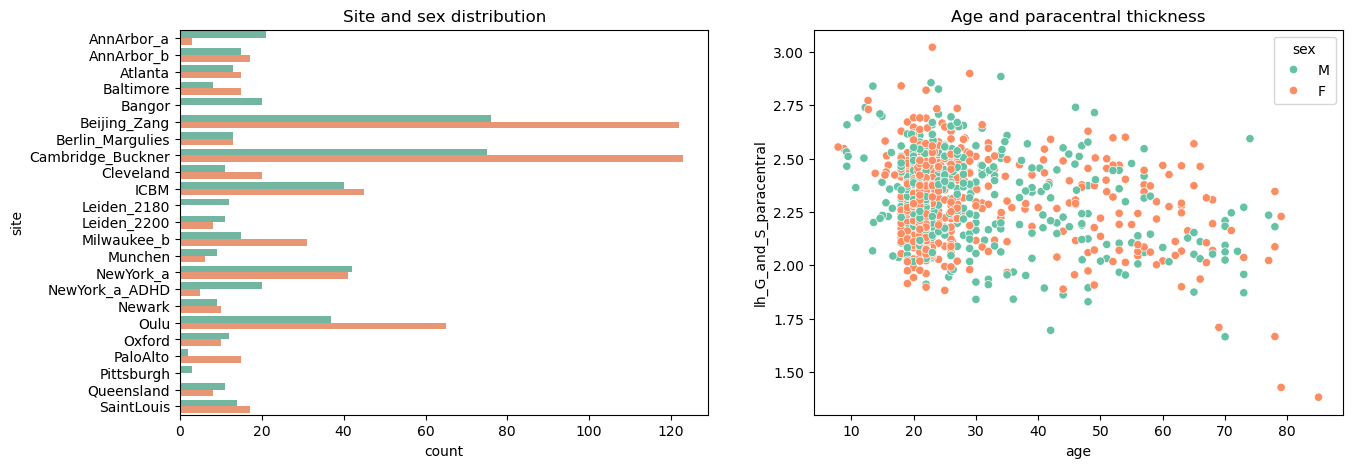

(1078, 154)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(y="site", data=df, ax=ax[0], hue="sex", palette="Set2", legend=False)
sns.scatterplot(
    x="age",
    y="lh_G_and_S_paracentral",
    data=df,
    ax=ax[1],
    hue="sex",
    palette="Set2",
)
ax[0].set_title("Site and sex distribution")
ax[1].set_title("Age and paracentral thickness")
plt.show()
df.shape

So the lists of covariates, batch effects, and response variables are:

In [4]:
subject_id = "sub_id"
covariates = ["age"]
batch_effects = ["site", "sex"]
response_variables = [
    col for col in df.columns if col not in covariates + batch_effects + [subject_id]
][:5]
response_variables = list(
    filter(lambda x: df[x].var() > 0, response_variables)
)  # Remove variables with no variance
print(response_variables)


['lh_G_and_S_frontomargin', 'lh_G_and_S_occipital_inf', 'lh_G_and_S_paracentral', 'lh_G_and_S_subcentral', 'lh_G_and_S_transv_frontopol']


## 1.2 Data preparation 🔪

Preparing the data for modelling consists of a few steps:
- dealing with missing values
- outlier removal
- combining different data sources
- train-test split 
- standardization

All these steps are implemented in the PCNtoolkit, the first three are provided by the `NormData` class, which we will use in the next code block.

For missingness and outliers, the PCNtoolkit will automatically remove the affected subjects in a row-wise manner. If another strategy is desired, the user can preprocess the data manually before passing it to the PCNtoolkit. 

For the train-test split, the PCNtoolkit will split the data into a train and test set using the `train_test_split` function from scikit-learn, and a stratification on batch effects is automatically carried out. Here, too, the user can choose to use another strategy and load the split data manually into the PCNtoolkit.

For standardization, the PCNtoolkit will store the standardization coefficients in the model object, so that the same scaling is applied to any new data that is used to make predictions.

-----

### Dealing with missing values and outliers

The PCNtoolkit uses the `NormData` class as a data container. Any data that is loaded into this class will be automatically checked for missing values and outliers, unless the user specifies otherwise. Affected subjects will be removed from the dataset.

Our model dataset has no missing values, so we will manually set some values to NaN for demonstration purposes. 


In [5]:
from pcntoolkit import NormData
import numpy as np

# Set some random values to NaN
df.iloc[2, 3] = None
df.iloc[5, 7] = np.nan

reference_norm_data = NormData.from_dataframe(
    name="fcon1000",
    dataframe=df,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_variables,
    subject_ids=subject_id,
    remove_Nan=True,
    remove_outliers=True,
    z_threshold=10,  # The default here is 3, but we use 10 for demonstration purposes
)

Process: 44905 - 2025-11-05 12:32:29 - Removed 2 NANs
Process: 44905 - 2025-11-05 12:32:29 - Removed 0 outliers
Process: 44905 - 2025-11-05 12:32:29 - Dataset "fcon1000" created.
    - 1076 observations
    - 1076 unique subjects
    - 1 covariates
    - 5 response variables
    - 2 batch effects:
    	site (23)
	sex (2)
    



------

### Combining different data sources

In many cases, our data comes from different sources. Here, we work with the FCON1000 dataset and the datasets downloaded from Openneuro. The first one is already loaded as the reference dataset above, now we will load the other data in NormData objects. We will then merge the healthy controls with the reference set, and keep the rest separate for later analysis. 

In [6]:
# # Split into healthy and patient groups
healthy_idx = openneuro_df["group"] == "HC"
healthy_group = openneuro_df[healthy_idx]
patient_groups = openneuro_df[~healthy_idx]

# Load the healthy and patient data
healthy_clinical_data = NormData.from_dataframe(
    name="openneuro_healthy",
    dataframe=healthy_group,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_variables,
    remove_Nan=True,
    remove_outliers=True,
)
patient_clinical_data = NormData.from_dataframe(
    name="openneuro_patient",
    dataframe=patient_groups,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_variables,
    remove_Nan=True,
    remove_outliers=True,
)
# Merge the healthy data with the reference data
norm_train = reference_norm_data.merge(healthy_clinical_data)

# Check if all the data is compatible, meaning that the covariates, response variables, and batch effects are the same
if not norm_train.check_compatibility(patient_clinical_data):
    raise ValueError("The data is not compatible")
else:
    print("The data is compatible")

Process: 44905 - 2025-11-05 12:32:29 - Removed 0 NANs
Process: 44905 - 2025-11-05 12:32:29 - Removed 1 outliers for lh_G_and_S_frontomargin
Process: 44905 - 2025-11-05 12:32:29 - Removed 1 outliers
Process: 44905 - 2025-11-05 12:32:29 - Dataset "openneuro_healthy" created.
    - 58 observations
    - 58 unique subjects
    - 1 covariates
    - 5 response variables
    - 2 batch effects:
    	site (2)
	sex (2)
    
Process: 44905 - 2025-11-05 12:32:29 - Removed 0 NANs
Process: 44905 - 2025-11-05 12:32:29 - Removed 1 outliers for lh_G_and_S_occipital_inf
Process: 44905 - 2025-11-05 12:32:29 - Removed 1 outliers
Process: 44905 - 2025-11-05 12:32:29 - Dataset "openneuro_patient" created.
    - 61 observations
    - 61 unique subjects
    - 1 covariates
    - 5 response variables
    - 2 batch effects:
    	site (2)
	sex (2)
    
Process: 44905 - 2025-11-05 12:32:29 - Dataset "fcon1000_+_openneuro_healthy" created.
    - 1134 observations
    - 1134 unique subjects
    - 1 covariates
    - 


-----

### Train-test split

The reference set is split into a train set and a test set. The train set is used to train the normative model, while the test set is used to assess the performance of the model. A trade-off has to be made between the size of the train set and the size of the test set. A larger train set will result in a more accurate normative model, but a larger test set will result in a more reliable performance assessment. We recommend using a 80%-20% or 70%-30% split for the train and test set, respectively.

For a correct performance assessment, the test set should be as statistically similar as possible to the train set. Stratification of the train-test split ensures that the distribution of the batch effect values in the train and test set are similar. 

The function `NormData.train_test_split` will perform a stratified train-test split on the batch effect dimensions, using the `train_test_split` function from scikit-learn. The stratification is done on batch effect dimensions. 




In [7]:
train, test = norm_train.train_test_split(
    splits=(0.8, 0.2), split_names=["train", "test"], random_state=42
)
print(len(train.observations))
print(len(test.observations))

907
227





-----

### Standardization

As said before, the PCNtoolkit will store the standardization coefficients in the model object, so that the same scaling is applied to any new data that is used to make predictions. This also means that none of the data scaling has to be done manually, and that it is as simple as configuring the inscaler and outscaler in the `NormativeModel` object, which is what we will do in the next step. 

## 1.3 Modelling 🥘

-----

### The NormativeModel class

The central class in the PCNtoolkit is the `NormativeModel` class. It has all functions that are required to build and use a normative model. Here we will list a few of the most important functions. For extensive documentation, please refer to the official documentation at https://predictive-clinical-neuroscience.github.io/pcntoolkit/

```NormativeModel.fit(data:NormData)```

This function fits the normative model to the training data.

```NormativeModel.predict(data:NormData)```

This function makes predictions on new data.

```NormativeModel.fit_predict(fit_data:NormData, predict_data:NormData)```

This function fits the normative model to the training data and makes predictions on new data.

```NormativeModel.save(path:Optional[str]=None)```

This function saves the normative model to a file. Uses the configured save path in the `NormativeModel` object, or the path argument if provided.

```NormativeModel.load(path:str)```

This function loads a normative model from a file.

```NormativeModel.transfer(data:NormData)```

This function transfers the normative model to a new dataset.

```NormativeModel.extend(data:NormData)```

This function extends the normative model to a new dataset.

```NormativeModel.merge(save_dir:str, models:list[Union[NormativeModel, str]])```

This function merges two or more normative models and saves the result as a new  `NormativeModel` object at the specified path, also returning the new `NormativeModel` object. Models can be passed as a list containing a number of `NormativeModel` objects or as a list of paths to saved `NormativeModel` objects, or a mix of both. 

```NormativeModel.synthesize(data:NormData, n_samples:int, covariate_range_per_batch_effect:bool=True)```

This function creates synthetic data that follows the learned data distribution. If `covariate_range_per_batch_effect` is `True`, the range from which the covariate values are sampled is different for each batch effect, and follows the distribution that was observed in the training data. 

```NormativeModel.harmonize(data:NormData, reference_batch_effect:dict[str,str] | None= None)```

This function harmonizes new data to the reference data distribution.


In [8]:
from pcntoolkit import NormativeModel, HBR

model = NormativeModel(
    template_regression_model=HBR(),  # The template regression model to use (note that we will elaborate on this next)
    savemodel=True,  # Whether to save the model after fitting -  defaults to True
    evaluate_model=True,  # Whether to evaluate the model after fitting -  defaults to True
    saveresults=True,  # Whether to save the results (Z_scores, centiles, logp, evaluation metrics) -  defaults to True
    saveplots=True,  # Whether to save the plots (centile curves and qq-plots) -  defaults to True
    save_dir="../out/models/main_workflow_model_default_HBR",  # The directory to save the model
    inscaler="standardize",  # The scaler to use for the covariates, defaults to standardize
    outscaler="standardize",  # The scaler to use for the response variables, defaults to standardize
    name="main_workflow_model_default_HBR",  # The name of the model
)


-----

### The RegressionModel class

We currently only support the creation of univariate normative models in the PCNtoolkit. This means that each `NormativeModel` object contains a collection of `RegressionModel` objects. For each response variable, the `NormativeModel` class makes a copy of a template regression and fits it to the response variable. This template is what the user should provide when creating a `NormativeModel`.  

The `RegressionModel` type currently has two concrete implementations; Bayesian Linear Regression (BLR) and Hierarchical Bayesian Regression (HBR). Each has its pros and cons, and we will discuss some of the differences, and how to choose between them, in the next section.


#### Bayesian Linear Regression (BLR)

The BLR algorithm in its most basic form assumes that features are normally distributed, conditioned on the covariates. It also assumes a conjugate on the regression coefficients, and optimizes those coefficient using a gradient method based on Bishop's Pattern Recognition and Machine Learning (2006). The batch effects in BLR are modeled as fixed effects, they are encoded as dummy indicator variables and concatenated to the design matrix. Batch effects can be modeled in both the slope and the intercept. Heteroskedasticity is also possible, and also there we can have batch effects in the intercept of the variance (the variance when the covariates are 0), and slope of the variance (the strength of the effect the covariates have on the variance).

Non-Gaussian features can also be modeled accurately by BLR if we learn an additional transformation - a warp - of the input features. The PCNtoolkit comes equiped with a number of options for warping, but the most useful one is the Sinh-Arcsinh mapping, which modulates the skewness and kurtosis of the distribution to which it is applied. With this warp, a wide range of non-Gaussian distributions can be covered.  

Finally, the BLR model also takes some arguments for the optimization. The defaults should work well in most cases. The below configuration shows all the default additional parameters explicitly.


In [9]:
from pcntoolkit import BLR, BsplineBasisFunction, LinearBasisFunction

blr = BLR(
    # A temporary name to give to your regression model (after fitting, each individual regression model will carry the name of the feature it models)
    name="template_blr",
    # Whether to model a group-specific offset of the mean
    fixed_effect=True,
    # Whether to model a group-specific slope of the mean
    fixed_effect_slope=True,
    # Whether to model heteroskedasticity
    heteroskedastic=True,
    # Whether to model a group-specific offset of the variance
    fixed_effect_var=True,
    # Whether to model a group-specific effect of the covariates on the variance
    fixed_effect_var_slope=False,
    # The warp to use
    warp_name="WarpSinhArcSinh",
    # The basis function to use for the mean regression
    basis_function_mean=BsplineBasisFunction(degree=3, nknots=5),
    # The basis function to use for the variance regression
    basis_function_var=LinearBasisFunction(),
    ### Optimizer parameters
    # The maximum number of iterations to run the optimizer
    n_iter=100,
    # The tolerance for the optimizer
    tol=0.001,
    # Whether to use the Automatic Relevance Determination (ARD) method
    ard=False,
    # The optimizer to use
    optimizer="l-bfgs-b",
    # The L-BFGS-B optimizer parameters
    l_bfgs_b_l=0.1,
    # The epsilon parameter for the L-BFGS-B optimizer
    l_bfgs_b_epsilon=0.1,
    # The norm to use for the L-BFGS-B optimizer
    l_bfgs_b_norm="l2",
    # The initial guess for the hyperparameters
    hyp0=None,
)



#### Hierarchical Bayesian Regression (HBR)

A HBR model assumes a hierarchical generative model on the data, and performs full posterior estimation using Markov Chain Monte-Carlo. Configuring a HBR model amounts to configuring the specifics of the generative model, which always consists of a likelihood and its parameters. 

Here we list the most important likelihoods supported by the PCNtoolkit, when to use them, the parameters they require, and the ranges of the parameters.

<details>
<summary> Normal Likelihood </summary>

  - Use when the data is (approximately) normally distributed conditioned on the covariates.
  - Parameters:
    - `mu`  
      -  encodes the mean of the distribution 
      -  $\mu \in (-\infty, \infty)$
    - `sigma` - encodes the variance of the distribution
      - encodes the variance of the distribution
      - $\sigma  \in [0, \infty)$
</details>

<details>
<summary> SHASHb Likelihood </summary>

  - Use then the data is not normally distributed, and unbounded.
  - Parameters:
    - `mu` 
      - encodes the mean of the distribution
      - $\mu \in (-\infty, \infty)$
    - `sigma` 
      - encodes the variance of the distribution
      - $\sigma  \in [0, \infty)$
    - `epsilon` 
      - ecodes the skewness of the distribution
      - $\epsilon \in (-\infty, \infty)$
    - `delta` 
      - encodes the kurtosis of the distribution
      - $\delta \in [0, \infty)$
</details>

<details>
<summary> Beta Likelihood </summary>

  - Use when the data is not normally distributed, and falls within a strict range. 
  - Parameters:
    - `alpha` 
    - encodes the tendency towards the upper limit of the range
      - $\alpha \in [0, \infty)$
    - `beta` 
      - encodes the tendency towards the lower limit of the range
      - $\beta \in [0, \infty)$
</details>

For this example, we will use the normal likelihood, which has two easily interpretable parameters, mu and sigma. For more details on the parameterisation of the SHASHb and Beta likelihoods, please refer to the [PCNtoolkit documentation](https://pcntoolkit.readthedocs.io/en/latest/).

With the choice of the likelihood made, we have to configure each of parameters' priors separately, which, in the PCNtoolkit, can be done with the `make_prior` function. For most models, there are multiple nested calls of `make_prior` required - it is a hierarchical model, after all. For a generic parameter $\theta$, we follow this schema:

1. Do we want $\theta$ to vary as a function of the covariates?
   1. Yes: 
      - pass `linear=True`
      - configure parameters `basis_function`, `slope` and `offset` according to this schema and pass them to the `make_prior` function. 
        <details>
        <summary> Details on configuring linear HBR parameters</summary>

        `Slope` and `offset` respectively correspond to $w$ and $\tau$ in the following equation: 

        \begin{align}
        w_n &\sim p_w(w_n) \\
        \tau_n &\sim p_\tau(\tau_n)\\
        \theta_n &= w_n^T\phi(x_n) + \tau_n
        \end{align}

        Where $x_n$ is the $n$'th set of covariates, $\phi$ is the basis function.

        As should be clear from the equations, $w$ and $\tau$ both have their own priors, $p_w$ and $p_\tau$. These should _not_ be linear, but may have a random effect, which is why they have a subscript $n$ to indicate that they may differ for each datapoint. 

        </details>
  
   2. No:
      1. Do we want $\theta$ to have a batch effect?
         1. Yes:
            - pass `random=True`
            - configure parameters `mu` and `sigma` according to this schema and pass them to the `make_prior` function. 
              <details>
              <summary> Details on configuring random HBR parameters</summary>

              Configuration of random parameters in the PCNtoolkit follows a non-centered schema to avoid Neal's funnel discussed here: [https://crackedbassoon.com/writing/funneling](https://crackedbassoon.com/writing/funneling). Essentially, parameters with a random effect vary around a common mean, and are further composed by a sum of group-specific offsets, which all follow normal distributions. For instance, a parameter with batch effects of site and sex is modeled as a sum of the common mean, the site-specific offset, and the sex-specific offset. 
      
          


              More formally, 
              - Let $\beta$ be the number of batch effect dimensions, i.e. for batch effects (site, sex), $\beta = 2$.
              - Let $N$ denote the number of observations/datapoints.
              - Let $v_b$ denote the number of unique batch effect values of the $b$'th batch effect dimension. I.e. if there are two unique sexes and five unique sites, $v_0 = 2$ and $v_1 = 5$.
              - Let $Z$ denote the $N \times \beta$ matrix of batch effect indices.
  
              Then:

              \begin{align}
                \mu_{\theta} &\sim p_\mu(\mu_\theta)\\
                \sigma_{{\theta}_b} &\sim p_\sigma(\sigma_{{\theta}_b}) & \text{ where } p_\sigma(\theta') = 0 \text{ for all } \theta' \leq 0\\ 
                \nu_{{\theta}_b} &\sim \mathcal{N}(\nu_{{\theta}_b} \mid \mathbf{0}^{v_b}, \mathbf{I}^{v_b})\\
                \theta_n &= \mu_{\theta} + \sum_{b=1}^B \sigma_{{\theta}_b}\nu_{{\theta}_b}[Z_{n,b}]
              \end{align}

              Here we see that $\mu_\theta$ and each of the $\beta$ $\sigma$'s need their own priors. $\mu_\theta$ is the common mean. The offsets $\nu$ are sampled from a standard 1-d Gaussian, and scaled using $\sigma$. Sigma therefore encodes the standard deviation of the offsets, through a reparameterization. This is why, as we will see, the prior of $\sigma$ has to be strictly positive, which we can enforce using a mapping to the positive domain.    
                  
              </details>  

         2. No:
            - This is a single fixed parameter, identically modeled for each datapoint, without any linear or batch effects.
            - pass the `dist_name` and `dist_params` arguments and optionally the `mapping` and `mapping_params` to `make_prior`. 
              <details>
              <summary> Details on configuring single, fixed parameters </summary>

                 Single, fixed parameters are sampled from a known distribution and directly used as likelihood parameters (such as $\mu$ and $\sigma$ for the normal likelihood), or as hierarchical parameters (such as $\sigma_\theta$ in random parameters, or $w_n$ in linear parameters). Thus, we will have to configure that known distribution, its parameters, and optionally a mapping if the parameter has to be strictly positive. 

                 The mapping can be any function $\mathbb{R} \to \mathbb{R^+}$, and it is parameterized by a 3-tuple $(a,b,c)$, which encode x-shift, scale, and y-shift respectively. For any mapping $f$, the mapped output $y$ is computed as $$y = f((x-a)/b)\cdot b + c.$$ The default values for $a$, $b$, and $c$ in the PCNtoolkit are 0, 1, and 0 naturally, such that $y=f(x)$. The PCNtoolkit allows passing either $(a,b,c)$ or $(a,b)$, in which $c$ will be taken to be 0. 

                 
                 So, without a mapping, a single fixed $\theta$ is sampled as:

                 \begin{align}
                 \theta &\sim p_\theta(\theta)
                 \end{align}

                 And with a mapping, it is sampled as:

                 \begin{align}
                 \theta &\sim p_\theta(\theta)\\
                 \theta^+ &= f((\theta-a)/b)\cdot b + c
                 \end{align}



          </details>


Finally, to complete the configuration of the HBR model, we have to configure the sampler. The defaults sampler settings work well. Below is an example configurations, with all the defaults sampler parameters explicated.  

In [ ]:
from pcntoolkit import make_prior, BsplineBasisFunction, NormalLikelihood, HBR

mu = make_prior(
    # Mu is linear because we want to allow the mean to vary as a function of the covariates.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 10.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    # The intercept is random, because we expect the intercept to vary between sites and sexes.
    intercept=make_prior(
        random=True,
        # Mu is the mean of the intercept, which is normally distributed with a mean of 0 and a standard deviation of 1.
        mu=make_prior(dist_name="Normal", dist_params=(0.0, 3.0)),
        # Sigma is the scale at which the intercepts vary. It is a positive parameter, so we have to map it to the positive domain.
        sigma=make_prior(
            dist_name="Normal",
            dist_params=(0.0, 3.0),
            mapping="softplus",
            mapping_params=(0.0, 3.0),
        ),
    ),
    # We use a B-spline basis function to allow for non-linearity in the mean.
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
sigma = make_prior(
    # Sigma is also linear, because we want to allow the standard deviation to vary as a function of the covariates: heteroskedasticity.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 2.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 5.0)),
    # The intercept is not random, because we assume the intercept of the variance to be the same for all sites and sexes.
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 3.0)),
    # We use a B-spline basis function to allow for non-linearity in the standard deviation.
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    # We use a softplus mapping to ensure that sigma is strictly positive.
    mapping="softplus",
    # We scale the softplus mapping by a factor of 3, to avoid spikes in the resulting density.
    # The parameters (a, b, c) provided to a mapping f are used as: f_abc(x) = f((x - a) / b) * b + c
    # This basically provides an affine transformation of the softplus function.
    # a -> horizontal shift
    # b -> scaling
    # c -> vertical shift
    # You can leave c out, and it will default to 0.
    mapping_params=(0.0, 3.0),
)

# Set the likelihood with the priors we just created.
likelihood = NormalLikelihood(mu, sigma)

template_hbr = HBR(
    name="template_hbr",
    # The likelihood we just created.
    likelihood=likelihood,
    ### Sampling parameters
    # The number of draws to sample from the posterior per chain.
    draws=1500,
    # The number of tuning steps to run.
    tune=500,
    # The number of cores to use for sampling.
    cores=4,
    # The number of MCMC chains to run.
    chains=4,
    # The sampler to use for the model.
    nuts_sampler="nutpie",
    # The initialisation method for the samples
    init="jitter+adapt_diag",
    # Whether to show a progress bar during the model fitting.
    progressbar=True,
)



----


### Combining the NormativeModel and RegressionModel classes

We already saw how to create a `NormativeModel`, but then we used the default HBR model. Now we will use the template HBR model that we just configured. 

In [ ]:
model = NormativeModel(
    template_regression_model=template_hbr,  # The HBR model we just configured
    save_dir="../out/models/main_workflow_model_HBR",  # The path where the model will be saved
)


----- 

### Fitting the normative model to the data

Now we have everything configured:
1. We selected the data
2. We prepared the data by preprocessing and splitting into train and test set
3. We configured the template regression model
4. We configured the normative model

All we have to do is fit the model to the train set, and predict on the test set, which we can do in a single call to `fit_predict`. It will fit and save the model, make predictions on the train and test set, and also save those. By default, the model will also make plots and save those.  

In [ ]:
import time

start_time = time.time()
model.fit_predict(train, test)
end_time = time.time()

In [ ]:
print(f"Time taken: {end_time - start_time} seconds")
# Time taken: 5872.371377229691 seconds

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# Load and show an example idata.nc file
idata = az.from_netcdf(
    "../out/models/main_workflow_model_HBR/model/lh_G_and_S_frontomargin/idata.nc"
)

display(idata)

# Show the summary of the idata.nc file
# pd.set_option('display.max_rows', 100) # This is to show all rows in the summary
display(az.summary(idata))

# Plot the trace of the idata.nc file
az.plot_trace(idata, compact=True, figsize=(7, 15))
plt.tight_layout()
plt.show()

The summary of the idata file shows us that, at least for this response varaible, all variables have an Rhat lower than 1.01. This is good, because it means that all chains have converged to almost the same disribution, and that the fit is therefore reliable. The trace plots show nice convergence too. The density plots on the LHS show agreement between the chains (plotted with different markers), and the plots on the RHS are uncorrelated 'caterpillars', which usually indicates convergence. 

We can also interpret some of the plots on the LHS. For instance, in the bottom `sex_offset_intercept_mu` plot, we see the learned difference between the sexes, and in the `site_offset_intercept_mu` plot, we see the differences between the sites. 

## 1.4 Evaluation 🍲

The PCNtoolkit helps the user evaluating their models by saving informative plots and a dataframe with evaluation metrics. These can be found in the model save directory under `plots` and `results` respectively. 

### Evaluation metrics and their meaning

The table below provides an overview of the evaluation metrics provided by the PCNtoolkit. 

The rightmost column indicates whether the metric is computed using only the expected value of a feature, $\hat{y}$. Because a normative model not only estimates the expected value, but also the variance and sometimes the shape of the distribution, the metrics that are marked with 'Yes' in this column should not be given too much importance. See section [2.2](2.2_model_comparison.ipynb) for a more in-depth discussion.

| Abbreviation | Full Name and useful link                     | What it measures                                                                 | Interpretation                                                                 |  Mean-based |
|--------------|----------------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------|---|
| EXPV         | [Explained Variance](https://en.wikipedia.org/wiki/Explained_variation)                    | Proportion of variance in the data explained by the model (similar to R², but can differ). | Closer to **1** = better (0 means no variance explained, negative means worse than mean predictor)| Yes | 
| MACE         | [Mean Absolute Centile Error](https://www.biorxiv.org/content/biorxiv/early/2025/06/25/2025.06.23.660997.full.pdf)         | Average absolute deviation of predictions from targets expressed in percentiles.  | Closer to **0** = better (0 means perfect percentile alignment, higher means worse calibration). | No |
| MAPE         | [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)        | Average of absolute percentage errors between prediction and true values.         | Closer to **0%** = better (can blow up if actual values are close to 0). | No | 
| MSLL         | [Mean Standardized Log Loss](https://direct.mit.edu/books/oa-monograph-pdf/2514321/book_9780262256834.pdf)            | Compares model log-likelihood to a baseline, standardized by data variance.       | **Lower** is better (0 = same as baseline, negative = better than baseline, positive = worse). | Yes | 
| NLL          | [Negative Log-Likelihood](https://docs.pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)                | Likelihood-based measure of model fit.                          | **Lower** is better (0 = perfect likelihood, large positive = poor fit). | No | 
| R2           | [Coefficient of Determination (R²)](https://en.wikipedia.org/wiki/Coefficient_of_determination)     | Fraction of variance in target explained by the model.                            | Closer to **1** = better (0 means no variance explained, negative means worse than mean predictor). | Yes | 
| RMSE         | [Root Mean Squared Error](https://en.wikipedia.org/wiki/Root_mean_square_deviation)                | Square root of the mean squared difference between predictions and true values.   | Closer to **0** = better (represents error in original units of the target). | Yes | 
| Rho          | [Pearson Correlation Coefficient (ρ)](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)   | Linear correlation between predicted and true values.                             | Closer to **1** or **-1** = stronger correlation (0 = no linear correlation). | No |
| Rho_p        | [p-value for Pearson’s ρ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)            | Statistical significance of the correlation.                                      | Closer to **0** = stronger evidence of correlation (usually p < 0.05 is significant). | No | 
| SMSE         | [Standardized Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)        | MSE normalized by the variance of the true data (relative measure of fit).        | Closer to **0** = better (1 = as bad as predicting the mean, >1 = worse than mean predictor). | Yes  | 
| ShapiroW     | [Shapiro–Wilk Test Statistic](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)            | Tests normality of residuals (how Gaussian the errors are).                       | Values close to **1** = residuals look normal. Low values with small p-value indicate non-normality. | No | 


### Loading the table of evaluation metrics
And here's the table of the evaluation metrics on the first five features in our test set:

In [ ]:
# Either we can load it from the test NormData object (if it still exists in memory)
table = test.get_statistics_df().round(3)
display(table)
del table

# Or we can load it from its save location
table = pd.read_csv(
    "../out/models/main_workflow_model_HBR/results/statistics_test.csv",
    index_col="statistic",
).T.round(3)
table

### Interpretation of the above table

1. **EXPV** - Not the most informative measure for NM's, because NM's do more then just predicting the mean. These values are modest, but let's have a look at the plots of the _lh\_G\_and\_S\_occipital\_inf_ later. 
2. **MACE** - Close to zero for all features, this is good, it means our centiles match the true data distribution very well. 
3. **MAPE** - Also close to zero. This feature needs to be taken with caution in cases where the actual (the measured value) is very small relative to the variance.
4. **MSLL** - All negative, so our model is better than a simple baseline model. 
5. **NLL** - Not perfect, but still good, very much in line with the expectation for NLL. 
6. **R2** - Almost exactly mirrors EXPV, no surprises here. 
7. **RMSE** - The values all look good, but it can not be said with certainty without knowing the scale of the measurement. 
8. **Rho** - All values indicate that there is a modest correlation between the predicted and actual values. Good, but not perfect.
9. **Rho_p** - All are close to zero, meaning that all correlations are strongly significant, even though they are relatively small.
10. **SMSE** - These values are all quite large, which indicates that the models do not perform much better than just predicting the mean. Luckily, evaluating NMs is not as simple as just looking at the mean prediction. 
11. **ShapiroW** - All close to 1, which means that all our deviation scores taken together are approximately normally distributed, which is something we do care about.  

From these numbers we can conclude that the model does a good job at fitting to the held-out test data, which means it probably generalizes to other data sources too. We ca


### Interpretation of the plots

We saw that _lh\_G\_and\_S\_occipital\_inf_ had a relatively low Explained Variance and R2 score. We can inspect the plots to get an idea why that may be. 

In [ ]:
import matplotlib.pyplot as plt
import PIL.Image as image
from pathlib import Path

centiles = image.open(
    Path(model.save_dir) / "plots/centiles_lh_G_and_S_occipital_inf_test_harmonized.png"
)
plt.imshow(centiles)
plt.axis("off")
plt.show()

The centile plot, which plots _lh\_G\_and\_S\_occipital\_inf_ against age, reveals the answer. The centiles are horizontally oriented almost everywhere, which means that there is almost no age-related growth of this cortical feature. If we recall the formula for R2, we can understand why it is almost zero if this is the case. 

$$EXPV(Y, \hat{Y}) = 1 - \frac{RSS}{TSS} = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \mu)^2}$$

Where $Y$ is the response variable, $\hat{R}$ is the vector of predictions, and $\mu$ is the mean of $Y$. 

The expression equals 0 if the fraction equals 1, which is the case if the above and below terms are equal (and non-zero), and that can only happen if $\hat{y}_i$ is equal to $\mu$ for all $i$. In that case, the predicted mean takes on an identical value ($\mu$) for all observations, i.e. the model predicts a flat mean, which coincides with the actual mean of the data. This describes what can be seen in the plot. The predicted mean that we see is almost flat (for most observed ages, at least), and coincides with the actual mean of the data. 

Still, the model fits the actual variance of the data quite well, and can be called a good normative model regardless of the bad R2 score. The low R2 and EXPV scores should not be taken as a reason to reject a normative model, but rather as an indication that the predicted deviation scores do not differ much from the the naive Z-score:

$$z_i = \frac{y_i - E[Y]}{\sqrt{E[Y^2]-E[Y]^2}}$$

### Plotting

The PCNtoolkit has three built-in plotting functions:
1. `plot_centiles` - produces a centile plot of each feature, either with or without scatter data and conditionals
2. `plot_qq` - produces a qq-plot for each feature, where the data can be split by any of the batch_effects
3. `plot_ridge` - produces a ridge plot for each feature, either of Y or Z

We will go over each of them, and their options. 


Process: 44905 - 2025-11-05 12:32:40 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 5 response variables
    - 2 batch effects:
    	site (1)
	sex (1)
    
Process: 44905 - 2025-11-05 12:32:40 - Computing centiles for 5 response variables.
Process: 44905 - 2025-11-05 12:32:40 - Computing centiles for lh_G_and_S_transv_frontopol.


Sampling: []
Sampling: []
Sampling: []
Sampling: []


Process: 44905 - 2025-11-05 12:32:41 - Computing centiles for lh_G_and_S_frontomargin.


Sampling: []
Sampling: []
Sampling: []


Process: 44905 - 2025-11-05 12:32:42 - Computing centiles for lh_G_and_S_occipital_inf.


Sampling: []
Sampling: []
Sampling: []


Process: 44905 - 2025-11-05 12:32:43 - Computing centiles for lh_G_and_S_subcentral.


Sampling: []
Sampling: []
Sampling: []


Process: 44905 - 2025-11-05 12:32:43 - Computing centiles for lh_G_and_S_paracentral.


Sampling: []
Sampling: []


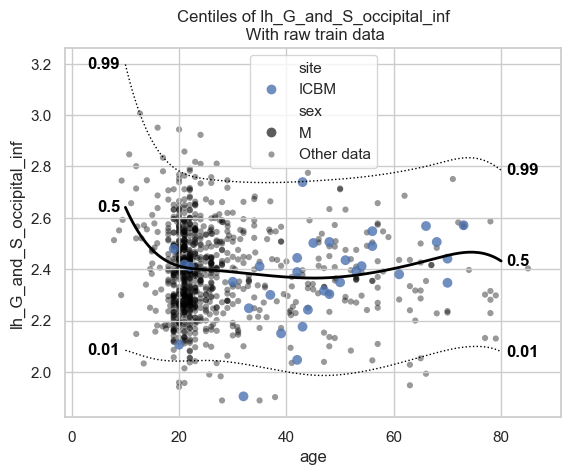

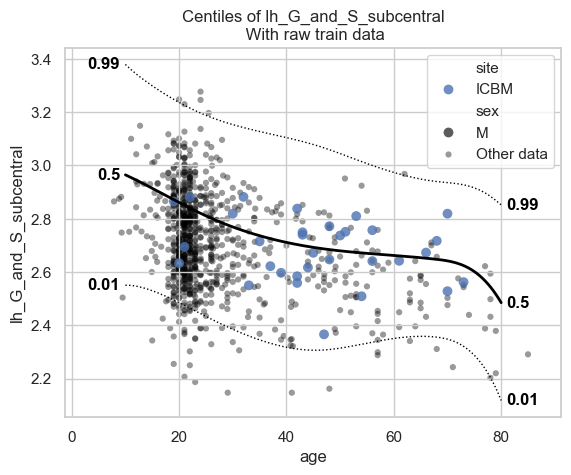

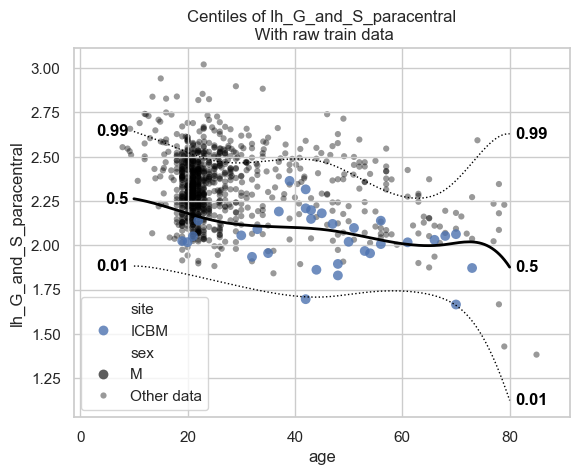

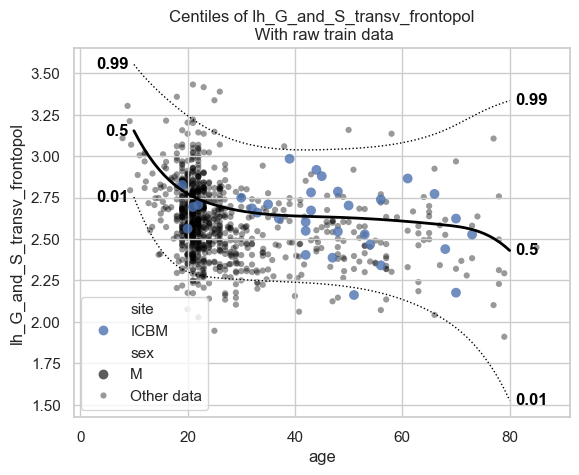

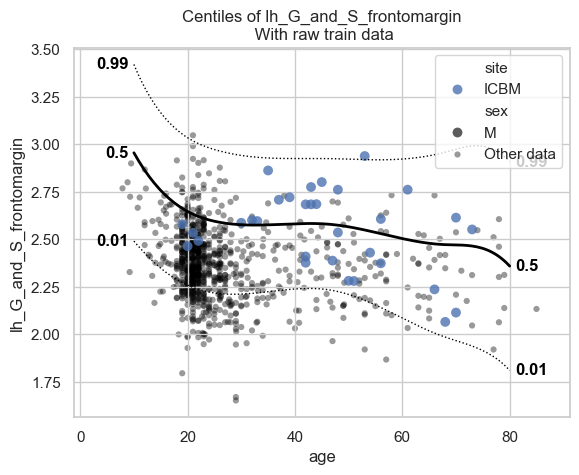

In [11]:
from pcntoolkit import plot_centiles, plot_qq, plot_ridge
# ['AnnArbor_a' 'AnnArbor_b' 'Atlanta' 'Baltimore' 'Bangor' 'Beijing_Zang'
#  'Berlin_Margulies' 'Cambridge_Buckner' 'Cleveland' 'ICBM' 'Leiden_2180'
#  'Leiden_2200' 'Milwaukee_b' 'Munchen' 'NewYork_a' 'NewYork_a_ADHD'
#  'Newark' 'Oulu' 'Oxford' 'PaloAlto' 'Pittsburgh' 'Queensland'
#  'SaintLouis']

model = NormativeModel.load("/Users/stijndeboer/Projects/Protocol_update/protocol_update_code/out/models/main_workflow_model_HBR")
plot_centiles(
    model,
    centiles=[0.01, 0.5, 0.99],
    covariate="age",
    covariate_range=(10, 80),
    batch_effects={"site": ["ICBM"], "sex": ["M"]},
    scatter_data = train,
    harmonize_data=False,
    hue_data="site",
    markers_data="sex",
    show_other_data=True,
    show_centile_labels=True,
    show_legend=True,
    show_yhat=False,
)


In [27]:
plot_centiles(
    model,
    centiles=[0.5, 0.95],
    covariate="age",
    covariate_range=(10, 80),
    batch_effects={"site": ["ICBM"], "sex": ["M"]},
    scatter_data = train,
    harmonize_data=True,
    hue_data="site",
    markers_data="sex",
    show_other_data=True,
    show_centile_labels=True,
    show_legend=True,
    show_yhat=False,
    save_dir="/Users/stijndeboer/Projects/Protocol_update/protocol_update_code/notebooks/images/1/centile_example"
)


Sampling: []


Process: 32307 - 2025-11-05 12:21:26 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 5 response variables
    - 2 batch effects:
    	site (1)
	sex (1)
    
Process: 32307 - 2025-11-05 12:21:26 - Computing centiles for 5 response variables.
Process: 32307 - 2025-11-05 12:21:26 - Computing centiles for lh_G_and_S_occipital_inf.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:27 - Computing centiles for lh_G_and_S_frontomargin.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:27 - Computing centiles for lh_G_and_S_subcentral.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:28 - Computing centiles for lh_G_and_S_transv_frontopol.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:28 - Computing centiles for lh_G_and_S_paracentral.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:29 - Harmonizing data on 5 response variables.
Process: 32307 - 2025-11-05 12:21:29 - Harmonizing data for lh_G_and_S_occipital_inf.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:29 - Harmonizing data for lh_G_and_S_frontomargin.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:30 - Harmonizing data for lh_G_and_S_subcentral.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:31 - Harmonizing data for lh_G_and_S_transv_frontopol.


Sampling: []
Sampling: []


Process: 32307 - 2025-11-05 12:21:31 - Harmonizing data for lh_G_and_S_paracentral.


Sampling: []


In [12]:


plot_qq(
    train,
    plot_id_line=True,
    save_dir="/Users/stijndeboer/Projects/Protocol_update/protocol_update_code/notebooks/images/1/qq-example"
)



KeyError: "[('Z', np.str_('lh_G_and_S_frontomargin'))] not in index"